# BDAT 1008 - 04 Data Collection and Curation 

# Shubham Chawla 200493036

## Question 1. Import the data using inferred schema. Log the time taken to import.

In [165]:
# Importing pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 

In [166]:
%%time
# Importing data using inferred schema
# Location and type of the file being imported
path = 'covid_19_202001_202007.csv'
file_type = "csv"

# CSV OPTIONS
infer_schema = "true" #By using this option spark will automatically go through the csv file and infer the schema of each column.
first_row_is_header = "true"
delimiter = ","

# Importing csv file
df = spark.read.format(file_type) \
  .option("inferSchema",infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(path)

CPU times: total: 15.6 ms
Wall time: 262 ms


## Question 2. Define the schema and then import the data using your defined schema. Log the time taken to import

In [167]:
%%time
from pyspark.sql.types import *

file_location = "covid_19_202001_202007.csv"

# Defining schema
CovidSchema = StructType([
  StructField("Province/State", StringType(), True),
  StructField("Country/Region", StringType(), True),
  StructField("Lat", DoubleType(), True),
  StructField("Long", DoubleType(), True),
  StructField("Date", StringType(), True),
  StructField("Confirmed", IntegerType(), True),
  StructField("Deaths", IntegerType(), True), 
  StructField("Recovered", IntegerType(), True),
  StructField("Active", IntegerType(), True),
  StructField("WHO Region", StringType(), True)])

df_with_schema = spark.read.format("csv") \
      .option("header", True) \
      .schema(CovidSchema) \
      .load(file_location)

CPU times: total: 0 ns
Wall time: 9.01 ms


## Question 3. Would you recommend creating a schema first before importing the data? Why?

### Answer
Execution Time for Inferred Schema = 262 ms
Execution Time for User Defined Schema = 9.01 ms

I would recommend defining schema explicitly rather than using the inferred schema as the problem with inferred schema is that it is quite memory intensive hence taking more time to execute, as Spark needs to read enough amount of data in order to correctly infer the type. 

## Question 4. Provide summary statistics on the dataset

In [171]:
# To allow horizontal scrolling
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [169]:
#Summary Statistics on the Dataset
df.describe().show()

+-------+--------------+--------------+------------------+------------------+----------+------------------+-----------------+-----------------+-----------------+---------------+
|summary|Province/State|Country/Region|               Lat|              Long|      Date|         Confirmed|           Deaths|        Recovered|           Active|     WHO Region|
+-------+--------------+--------------+------------------+------------------+----------+------------------+-----------------+-----------------+-----------------+---------------+
|  count|         14664|         49068|             49068|             49068|     49068|             49068|            49068|            49068|            49068|          49068|
|   mean|          null|          null|21.433730459769688|23.528236452106245|      null| 16884.90425531915|884.1791595337083|7915.713479253282| 8085.01161653216|           null|
| stddev|          null|          null| 24.95031982606509|  70.4427397445028|      null|127300.20527228026|631

## Question 5. For top 10 countries suffering from covid-19, plot the line charts to show the deaths from Jan 22, 2020 to July 27, 2020

### Pyspark Dataframe - Pivot Table

In [172]:
# Pivoting pyspark dataframe
pivotDF1 = df.groupBy("Country/Region", "Date") \
      .sum("Deaths") \
      .groupBy("Country/Region") \
      .pivot("Date") \
      .sum("sum(Deaths)") \

pivotDF1.show()

+--------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----

### Creating New Column for Row Totals - Total Deaths for sorting Countries by Total Deaths in the given time period.

In [173]:
# Storing all Column headers in x for creating summary column
x = pivotDF1.columns[1:]

# Creating Total Deaths Column
pivotDF1 = pivotDF1.withColumn('Total Deaths', sum(pivotDF1[col] for col in x))

# Sorting by Total Deaths
pivotDF1 = pivotDF1.sort('Total Deaths', ascending = False)

# Limiting to Top 10 countries after sorting
pivotDF1.select('Country/Region','Total Deaths').limit(10).show()

+--------------+------------+
|Country/Region|Total Deaths|
+--------------+------------+
|            US|    11011411|
|United Kingdom|     3997775|
|        Brazil|     3938034|
|         Italy|     3707717|
|        France|     3048524|
|         Spain|     3033030|
|        Mexico|     1728277|
|         India|     1111831|
|          Iran|     1024136|
|       Belgium|      963679|
+--------------+------------+



In [174]:
# dropping Totals Column
pivotDF1 = pivotDF1.limit(10).drop('Total Deaths')
pivotDF1.show()

+--------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----

In [175]:
# converting pyspark to pandas
pivotDF1_p = pivotDF1.toPandas()

# Setting Country/Region as index
pivotDF1_p = pivotDF1_p.set_index('Country/Region')
pivotDF1_p

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-07-18,2020-07-19,2020-07-20,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27
Country/Region,,,,,,,,,,,,,,,,,,,,,
US,0,0,0,0,0,0,0,0,0,0,...,140119,140534,141025,142121,143316,144430,145560,146465,146935,148011
United Kingdom,0,0,0,0,0,0,0,0,0,0,...,45358,45385,45397,45507,45586,45639,45762,45823,45837,45844
Brazil,0,0,0,0,0,0,0,0,0,0,...,78772,79488,80120,81487,82771,84082,85238,86449,87004,87618
Italy,0,0,0,0,0,0,0,0,0,0,...,35042,35045,35058,35073,35082,35092,35097,35102,35107,35112
France,0,0,0,0,0,0,0,0,0,0,...,30155,30155,30180,30168,30175,30185,30195,30195,30195,30212
Spain,0,0,0,0,0,0,0,0,0,0,...,28420,28420,28422,28424,28426,28429,28432,28432,28432,28432
Mexico,0,0,0,0,0,0,0,0,0,0,...,38888,39184,39485,40400,41190,41908,42645,42645,43680,44022
India,0,0,0,0,0,0,0,0,0,0,...,26816,27497,28082,28732,29861,30601,31358,32060,32771,33408
Iran,0,0,0,0,0,0,0,0,0,0,...,13979,14188,14405,14634,14853,15074,15289,15484,15700,15912


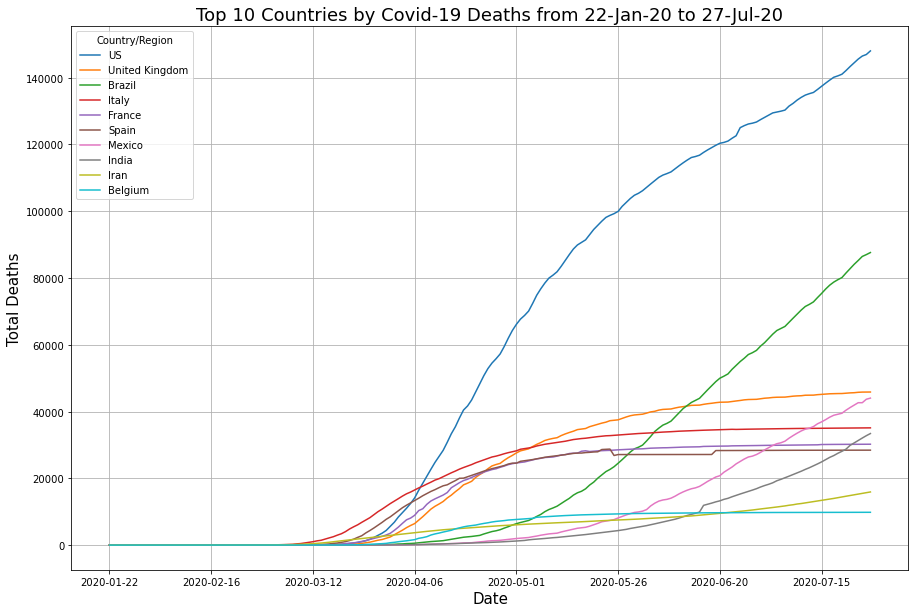

In [176]:
# Plotting Line Chart
%matplotlib inline
import matplotlib.pyplot as plt

# Figure size
fig, ax = plt.subplots(figsize=(15, 10))

# Using Transpose plot to plot columns on x axis
pivotDF1_p.T.plot(ax=ax)

# Title and labels
plt.title("Top 10 Countries by Covid-19 Deaths from 22-Jan-20 to 27-Jul-20", fontsize = 18)
plt.ylabel('Total Deaths',fontsize = 15)
plt.xlabel('Date', fontsize = 15)
ax.grid(True)
plt.show()

## Question 6. Plot the recovery rate (recovered cases / confirmed cases) for the period Jan 22, 2020 to July 27, 2020. Which 5 countries have a relatively higher recovery rate?

In [119]:
# Adding a calculated column - 'Recovery_Rate' in the pyspark dataframe df
import pyspark.sql.functions as func
df = df.withColumn("Recovery_Rate", (df.Recovered/df.Confirmed)*100) \
  .fillna(0) \

# Rounding the values in the calculated column to 2 decimal places
df = df.withColumn("Recovery_Rate", func.round(df["Recovery_Rate"], 2))

In [120]:
# Pivoting pyspark dataframe df
pivotDF2 = df.groupBy("Country/Region", "Date") \
      .mean("Recovery_Rate") \
      .groupBy("Country/Region") \
      .pivot("Date") \
      .mean("avg(Recovery_Rate)") \

pivotDF2.show(5)

+--------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----

In [121]:
# Creating a new calculated column - average recovery rate, rounding off to 2 decimal places
pivotDF2 = pivotDF2.withColumn("Avg Recovery Rate", func.round(sum(pivotDF2[col] for col in x)/len(x),2))

# Sorting by Avg Recovery Rate
pivotDF2 = pivotDF2.sort('Avg Recovery Rate', ascending = False)

# Limiting to Top 5 countries after sorting
pivotDF2.select('Country/Region','Avg Recovery Rate').limit(5).show()

+--------------+-----------------+
|Country/Region|Avg Recovery Rate|
+--------------+-----------------+
|         China|            75.06|
|      Cambodia|            70.42|
|      Thailand|            67.04|
|       Vietnam|            66.57|
| Liechtenstein|            63.58|
+--------------+-----------------+



In [122]:
# dropping Totals Column
pivotDF2 = pivotDF2.limit(5).drop('Avg Recovery Rate')

In [125]:
# converting pyspark to pandas
pivotDF2_p = pivotDF2.toPandas()

# Setting Country/Region as index
pivotDF2_p = pivotDF2_p.set_index('Country/Region')

# rounding all values to 2 decimal places
pivotDF2_p.round(2)

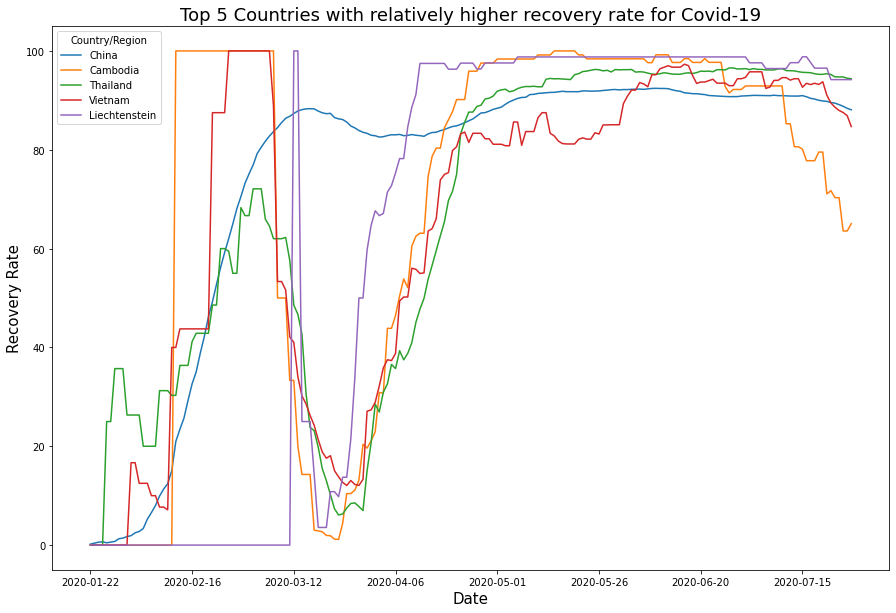

In [126]:
# Plotting Line Chart
%matplotlib inline
import matplotlib.pyplot as plt

# Figure size
fig, ax = plt.subplots(figsize=(15, 10))

# Using Transpose plot to plot columns on x axis
pivotDF2_p.T.plot(ax=ax)

plt.title("Top 5 Countries with relatively higher recovery rate for Covid-19", fontsize = 18)
plt.ylabel('Recovery Rate',fontsize = 15)
plt.xlabel('Date', fontsize = 15)

plt.show()

## Question 7. As of July 27, 2020, aggregate the confirmed cases, deaths, recovered cases and active cases group by WHO region

In [127]:
# Creating a temp view
df.createOrReplaceTempView("WHO")

sqlDF = spark.sql("SELECT `WHO Region`, SUM(Confirmed) AS `Total Confirmed`,SUM(Deaths) AS `Total Deaths`, SUM(Recovered) AS `Total Recovered`, SUM(Active) AS `Total Active` FROM WHO GROUP BY `WHO Region` ORDER BY `WHO Region` ")
sqlDF.show()

+--------------------+---------------+------------+---------------+------------+
|          WHO Region|Total Confirmed|Total Deaths|Total Recovered|Total Active|
+--------------------+---------------+------------+---------------+------------+
|              Africa|       21791827|      439978|       11193730|    10158119|
|            Americas|      402261194|    19359292|      157069444|   225832458|
|Eastern Mediterra...|       74082892|     1924029|       48050703|    24108160|
|              Europe|      248879793|    19271040|      123202075|   106406678|
|     South-East Asia|       55118365|     1458134|       30030327|    23629904|
|     Western Pacific|       26374411|      932430|       18861950|     6580031|
+--------------------+---------------+------------+---------------+------------+



In [128]:
# Converting pyspark df to pandas df
df_pd = sqlDF.toPandas()

In [129]:
# Making WHO region as index
df_pd = df_pd.set_index('WHO Region')
df_pd

,Total Confirmed,Total Deaths,Total Recovered,Total Active
WHO Region,,,,
Africa,21791827,439978,11193730,10158119
Americas,402261194,19359292,157069444,225832458
Eastern Mediterranean,74082892,1924029,48050703,24108160
Europe,248879793,19271040,123202075,106406678
South-East Asia,55118365,1458134,30030327,23629904
Western Pacific,26374411,932430,18861950,6580031


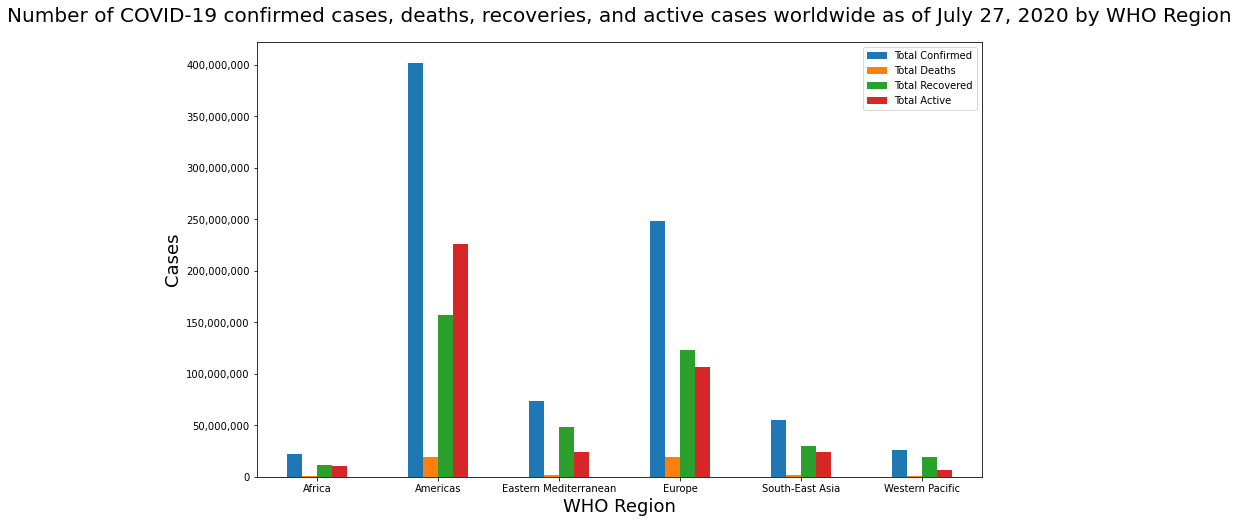

In [130]:
# bar chart
df_pd.plot.bar(figsize = (13,8))

#title
plt.title('Number of COVID-19 confirmed cases, deaths, recoveries, and active cases worldwide as of July 27, 2020 by WHO Region', fontsize = 20, pad = 20)

#labels
#x-axis
plt.xlabel('WHO Region',fontsize = 18)
plt.xticks(rotation = 'horizontal')

#y-axis
ax = plt.plot()
plt.ylabel('Cases', fontsize = 18)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

## Question 8. Which 5 countries have the highest growth rate on confirmed cases 3 months after the 1st positive case detected within the country?

In [177]:
# Pivoting pyspark dataframe
pivotDF3 = df.groupBy("Country/Region", "Date") \
      .sum("Confirmed") \
      .groupBy("Country/Region") \
      .pivot("Date") \
      .sum("sum(Confirmed)") \

pivotDF3.show()

+--------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----

### Finding Dates when 1st positive case was confirmed using pyspark sql

In [180]:
# Creating a temp view for dates when first cases were confirmed in a country
df.createOrReplaceTempView("firstcase")
firstcasedf = spark.sql("SELECT `Country/Region`, min(Date) AS `FirstCaseDate` FROM firstcase WHERE Confirmed > 0 GROUP BY `Country/Region`")
firstcasedf.show(3)

+--------------+-------------+
|Country/Region|FirstCaseDate|
+--------------+-------------+
|   Afghanistan|   2020-02-24|
|       Albania|   2020-03-09|
|       Algeria|   2020-02-25|
+--------------+-------------+
only showing top 3 rows



### Storing FirstCaseDate and Country in lists

In [184]:
startdate = []
startdate = list(firstcasedf.select('FirstCaseDate').toPandas()['FirstCaseDate']) 
country = list(firstcasedf.select('Country/Region').toPandas()['Country/Region'])
country.sort()
startdate[0:5]

['2020-02-24', '2020-03-09', '2020-02-25', '2020-03-02', '2020-03-20']

### Finding dates - 3 months after when 1st positive case was confirmed

In [186]:
# Extracting confirmed case values for date 90 days after when first case was detected
convert = []
enddate = []

from datetime import datetime
from datetime import timedelta

# converting startdate to datetime from str and adding 90 days
for i in range(0,187):
    convert.append(datetime.strptime(startdate[i], "%Y-%m-%d") + timedelta(days=90))

# converting datetime back to string
for i in range(0,187):
    enddate.append(convert[i].strftime("%Y-%m-%d"))
    
enddate[0:5]

['2020-05-24', '2020-06-07', '2020-05-25', '2020-05-31', '2020-06-18']

In [187]:
# Replacing Dates which are beyond 27 July to 27 July
enddate = list(map(lambda x: x.replace('2020-07-29', '2020-07-27'), enddate))
enddate = list(map(lambda x: x.replace('2020-08-11', '2020-07-27'), enddate))

### Using Pandas API on Spark to find out corresponding confirmed case values for these dates

In [190]:
# Converting spark dataframe to pandas on spark dataframe - Pandas API on Spark
psdf = pivotDF3.to_pandas_on_spark()
psdf = psdf.set_index('Country/Region')
type(psdf)

pyspark.pandas.frame.DataFrame

In [193]:
# Extracting confirmed case values for first case date
value1 = []
for i in range(0,187):
    value1.append(psdf.loc[country[i], startdate[i]])
    
value1[0:5]

[1, 2, 1, 1, 1]

In [194]:
# Extracting confirmed case values for date 90 days after when first case was detected
value2 = []
for i in range(0,187):
    value2.append(psdf.loc[country[i], enddate[i]])

value2[0:5]

[10582, 1246, 8503, 764, 166]

In [214]:
# Finding growth rate
growthRate = []
for i in range(0,187):
    # GR = Present Val - Past Val / Past Val
    growthRate.append((value2[i] - value1[i])/value1[i])

growthRate = [ '%.2f' % elem for elem in growthRate ] # rounding off values to 3 decimal places
growthRate[0:5]

['10581.00', '622.00', '8502.00', '763.00', '165.00']

In [258]:
# zipping country and growthRate together
a_zip = zip(country,growthRate)
res = dict(a_zip)

In [259]:
# exporting results to csv file
import csv

with open('results.csv', 'w') as f:
    for key in res.keys():
        f.write("%s, %s\n" % (key, res[key]))

In [267]:
file_location = "results.csv"

# Defining schema
resultschema = StructType([
  StructField("Country", StringType(), True),
  StructField("Growth Rate", DoubleType(), True)])

final_df = spark.read.format("csv") \
      .option("header", True) \
      .schema(resultschema) \
      .load(file_location)

In [272]:
# Top 5 countries with highest growth rate
final_df.sort(col("Growth Rate").desc()).limit(5).show()

+-------+-----------+
|Country|Growth Rate|
+-------+-----------+
|     US|   809317.0|
| Brazil|   391221.0|
|  Spain|   215215.0|
|   Peru|   183197.0|
| Turkey|   172113.0|
+-------+-----------+



## Question 9. For step 7, export the results to a JSON file

In [102]:
sqlDF.show()

+--------------------+---------------+------------+---------------+------------+
|          WHO Region|Total Confirmed|Total Deaths|Total Recovered|Total Active|
+--------------------+---------------+------------+---------------+------------+
|              Africa|       21791827|      439978|       11193730|    10158119|
|            Americas|      402261194|    19359292|      157069444|   225832458|
|Eastern Mediterra...|       74082892|     1924029|       48050703|    24108160|
|              Europe|      248879793|    19271040|      123202075|   106406678|
|     South-East Asia|       55118365|     1458134|       30030327|    23629904|
|     Western Pacific|       26374411|      932430|       18861950|     6580031|
+--------------------+---------------+------------+---------------+------------+



In [104]:
# Exporting the results to a JSON files
sqlDF.write.json("output.json")

In [105]:
# Reading json to check the results
df9 = spark.read.json("output.json")
df9.printSchema()
df9.show()

root
 |-- Total Active: long (nullable = true)
 |-- Total Confirmed: long (nullable = true)
 |-- Total Deaths: long (nullable = true)
 |-- Total Recovered: long (nullable = true)
 |-- WHO Region: string (nullable = true)

+------------+---------------+------------+---------------+--------------------+
|Total Active|Total Confirmed|Total Deaths|Total Recovered|          WHO Region|
+------------+---------------+------------+---------------+--------------------+
|    10158119|       21791827|      439978|       11193730|              Africa|
|   225832458|      402261194|    19359292|      157069444|            Americas|
|    24108160|       74082892|     1924029|       48050703|Eastern Mediterra...|
|   106406678|      248879793|    19271040|      123202075|              Europe|
|    23629904|       55118365|     1458134|       30030327|     South-East Asia|
|     6580031|       26374411|      932430|       18861950|     Western Pacific|
+------------+---------------+------------+------